In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from tqdm import tqdm_notebook
import regex as re

import os

In [3]:
IUPAC_WILDCARDS = {
    "W" : "AT",
    "S" : "CG",
    "M" : "AC",
    "K" : "GT",
    "R" : "AG",
    "Y" : "CT",
    "B" : "CGT",
    "D" : "AGT",
    "H" : "ACT",
    "V" : "ACG",
    "N" : "ACGT",
}

In [4]:
reverse = {
    "W" : "W",
    "S" : "S",
    "M" : "K",
    "K" : "M",
    "R" : "Y",
    "Y" : "R",
    "B" : "V",
    "D" : "H",
    "H" : "D",
    "V" : "B",
    "N" : "N",
    "A" : "T",
    "C" : "G", 
    "T" : "A",
    "G" : "C",
    "(" : "(",
    ")" : ")"
}

In [5]:
def rc(x, reverse = reverse, r=0):
    d = dict(zip(reverse.keys(), reverse.values()))
    if r:
        d["("] = ")"
        d[")"] = "("
        return ''.join([d[y] for y in x][::-1])
    else:
        return ''.join([d[y] for y in x])

In [6]:
def read_fastq(path):
    with open(path) as f:
        lines = f.readlines()
    
    reads = [x[:-1] for x in lines[1::4]]
    qualities = [x[:-1] for x in lines[3::4]]
    
    return reads, qualities

In [7]:
def repeat_to_re_pattern(repeat, e=2, d = IUPAC_WILDCARDS):
    re_pattern = "("
    for char in repeat:
        if char not in d.keys() and char != '(' and char != ')':
            re_pattern += char
        elif char in d.keys():
            re_pattern += "[" +  "|".join(d[char]) + "]"
    
    re_pattern += "){e<=" + str(e) + "}"
    return re_pattern

In [8]:
def find(repeat, read, e = 2):
    p_str = repeat_to_re_pattern(repeat,e=e)
    p = re.compile(p_str)
   
    return [x.span() for x in re.finditer(p, read)]

In [9]:
def split_read(read, quality, repeat, e=2, v=0):
    repeat, repeat_s, repeat_e = repeat.r, repeat.rs, repeat.re
    repeat_pos = find(repeat, read, e)
    
    if v: print(repeat_pos)
    if len(repeat_pos) == 0:
        return [-1, -1], [-1, -1]

    else:
        repeat_pos = repeat_pos[0]
        read_left = read[:repeat_pos[0]]
        q_left = quality[:repeat_pos[0]]
        
        read_right = read[repeat_pos[1]:]
        q_right = quality[repeat_pos[1]:]
        
        
        repeat_pos_l = find(repeat_e, read_left, e)
        if v: print(repeat_pos_l)
        if len(repeat_pos_l) == 0:
            left_spacer = -1
            left_sp_q = -1
        else:
            left_spacer = read_left[repeat_pos_l[0][1]:]
            left_sp_q = q_left[repeat_pos_l[0][1]:]
            
        
        repeat_pos_r = find(repeat_s, read_right, e)
        if v: print(repeat_pos_r)
        if len(repeat_pos_r) == 0:
            right_spacer = -1
            right_sp_q = -1
        else:
            right_spacer = read_right[:repeat_pos_r[0][0]]
            right_sp_q = q_right[:repeat_pos_r[0][0]]
            
        if left_spacer != -1 and len(left_spacer) <= 10:
            left_spacer = -1
        if right_spacer != -1 and len(right_spacer) <= 10:
            right_spacer = -1
        
        return [left_spacer, right_spacer], [left_sp_q, right_sp_q]

In [10]:
quality_symbols1 = r'!"#$%&' 
quality_symbols2 = "'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"

In [11]:
quality_dict = {}
quality_dict_r = {}
for i, char in enumerate(quality_symbols1 + quality_symbols2):
    quality_dict[char] = i
    quality_dict_r[i] = char

In [12]:
get_quality = lambda x: quality_dict[x]

In [13]:
def get_lowest_q(pair_q, gq = get_quality):
    return quality_dict[min(pair_q[0] + pair_q[1], key=gq)]

In [14]:
def save_pairs(path, name, pairs):
    name = name.split(".")[0]
    with open(path + name, 'w') as f:
        for p in pairs:
            f.write("\t".join(p))
            f.write("\n")
            

In [40]:
def main(path, name, repeat,  t = 10, v = 1):
    if v: print("reading :", name)
    reads, qualities = read_fastq(path + name)
    
    
    if v: print("cutting :", name)
    pairs, pairs_q = [], []
    for r,q in tqdm_notebook(zip(reads, qualities)):
        p, pq = split_read(r, q, repeat, e = 4)
        pairs.append(p)
        pairs_q.append(pq)
    
    
    if v: print("masking :", name)  
    pairs = np.array(pairs)
    pairs_q = np.array(pairs_q)
    
    
    mask = np.array(['-1' not in pair for pair in tqdm_notebook(pairs)])

    pairs = pairs[mask]
    pairs_q = pairs_q[mask]
      
    
    if mask.sum() ==0:
        return [], [], []
        
    min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])
    
    mask_2 = min_pq >= t
    
    print(name, mask.sum(), min(min_pq))
    
    return pairs, pairs_q, min_pq, mask_2

In [16]:
class Repeat:
    def __init__(self, r, rs, re, rc):
        self.r = r
        self.rs = rs
        self.re = re
        self.rc = rc

In [17]:
redundant = Repeat("GTTTTAKATTA(ACTAWRTGG)WATGTAAAK", 
                   "GTTTTAKATTAACTAWRTGG",
                   "ACTAWRTGGWATGTAAAK",
                   "GTTTTAKATTAACTAWRTGGWATGTAAAK")

non_redundant_1 = Repeat("GTTTTATATTA(ACTAAGTGG)TATGTAAAG",
                           "GTTTTATATTAACTAAGTGG",
                           "ACTAAGTGG)TATGTAAAG",
                           "GTTTTATATTAACTAAGTGGTATGTAAAG"
                          )

non_redundant_2 = Repeat("GTTTTATATTA(ACTATATGG)AATGTAAAT",
                           "GTTTTATATTAACTATATGG",
                           "ACTATATGGAATGTAAAT",
                           "GTTTTATATTAACTATATGGAATGTAAAT"
                          )

In [ ]:
Forward: GCG CCA GCG GGG ATA AAC C

Reverse: CGC TGG CGC GGG GAA CWC

In [ ]:
GWGTTCCCCGCGCCAGCG
         GCGCCAGCGGGGATAAACC
"GWGTTCCCC(GCGCCAGCG)GGGATAAACCG"

In [47]:
"GWGTTCCCC(GCGCCAGCG)GGGATAAACCG"[::-1]

'GCCAAATAGGG)GCGACCGCG(CCCCTTGWG'

In [79]:
ecoli_r = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GWGTTCCCCGCGCCAGCG",
                   "GCGCCAGCGGGGATAAACCG",
                   "GWGTTCCCCGCGCCAGCGGGGATAAACCG")

ecoli_r_1 = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GCCAAATAGGGGCGACCGCG",
                   "GCGACCGCGCCCCTTGWG",
                   "GCCAAATAGGGGCGACCGCGCCCCTTGWG")


In [19]:
def filter_by_q(pairs, pairs_q, t = 10):
    min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])
    
    mask_2 = min_pq >= t
    
    return pairs, pairs_q, min_pq, mask_2

In [32]:
path = "../data/student_Dvyg/EC/gz/"
#path = "../data/clostr_Polina/fastq/"

In [33]:
names = sorted(os.listdir(path))

In [52]:
def f(x):
    return main(path, x, ecoli_r_1)

In [23]:
res = f(names[0])

reading : DVyg24_S463_R1_001.fastq
cutting : DVyg24_S463_R1_001.fastq


A Jupyter Widget


masking : DVyg24_S463_R1_001.fastq


A Jupyter Widget


DVyg24_S463_R1_001.fastq 184413 2


In [32]:
res[3].sum()

184410

In [33]:
len(res[0])

184413

In [40]:
res_20 = filter_by_q(res[0], res[1], 20)

In [42]:
res_20[-1].sum()

101381

In [43]:
pairs = np.array(res_20[0])[res_20[-1]]

In [45]:
save_pairs("../data/student_Dvyg/EC/pairs_4/", names[0], pairs)

## hu

In [58]:
import sys
sys.path.append("./utils/")
import hierarcical_utils as hu
import plot_utils as pu 

In [47]:
gr = hu.graph_from_raw("../data/student_Dvyg/EC/pairs_4/DVyg24_S463_R1_001", split='\t')

reading pairs, clustering...
making sp_to_n...


A Jupyter Widget


processing pairs...


A Jupyter Widget


making graph...


In [48]:
gr[0].shape

(337, 337)

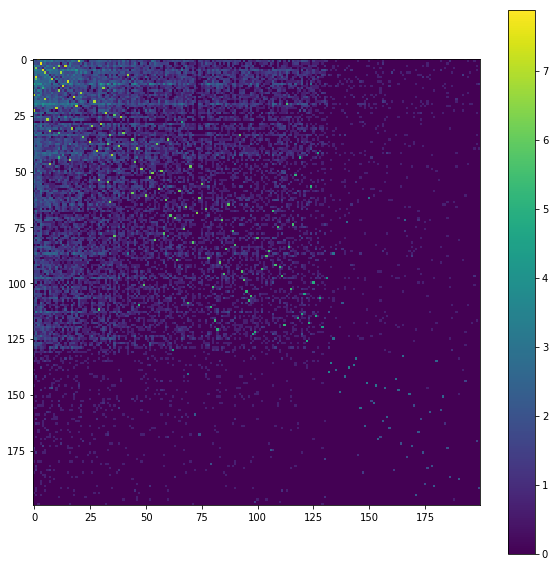

In [49]:
pu.plot_gr(gr[0][:200, :200], log =1)

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
import hamiltonian_utils as hamu

In [52]:
arrs, ws = hamu.restore_arrays(gr[0],threashold=2)

In [53]:
arrs = np.array(arrs)
ws = np.array(ws)

In [54]:
arrs

array([list([51, 53, 52, 117, 81, 54, 29, 30, 26, 39, 38, 55, 33, 40, 46, 45, 16, 0, 2, 3, 14, 11, 37, 25]),
       list([43, 35, 22, 10, 15, 21, 19, 27, 6, 12, 13, 31, 17, 18, 5, 4, 9, 8, 1, 20, 113]),
       list([41, 28, 66, 68, 107, 128]), list([24, 32]),
       list([88, 104, 95, 93, 110, 47, 7, 42, 127]),
       list([101, 49, 48, 70, 61, 50, 57, 124]),
       list([76, 67, 77, 89, 78, 58, 56, 75, 109, 69, 73, 140, 132]),
       list([91, 83, 90, 64, 34, 92, 108, 96, 85, 86, 105, 121, 82, 71, 63, 59, 65, 87, 134, 144, 193]),
       list([205, 188, 190, 175, 106, 97, 111, 79, 36, 60, 44, 119, 112, 23]),
       list([191, 179, 130, 62, 74, 116, 118, 123, 98, 131]),
       list([136, 133, 165, 159, 72, 84, 114, 120, 129]),
       list([103, 115, 126, 122, 99, 94, 102, 80, 100, 125]),
       list([138, 141]),
       list([184, 161, 173, 169, 155, 170, 154, 152, 233, 142, 139, 135, 180]),
       list([145, 149, 137, 143, 162, 156, 146, 153, 151, 183, 176, 174, 185, 147, 157, 182, 178,

<Container object of 25 artists>

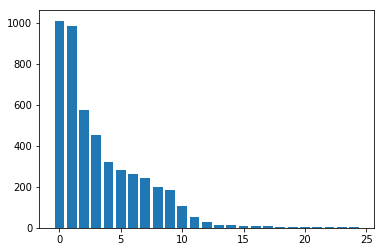

In [55]:
plt.bar(np.arange(len(ws)), sorted([np.median(x) for x in ws])[::-1])

<Container object of 25 artists>

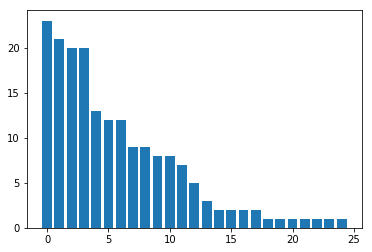

In [56]:
plt.bar(np.arange(len(ws)), sorted([len(x) for x in ws])[::-1])

In [57]:
gr_arrs = hamu.list_to_gr(arrs, gr[0].shape[0])

In [58]:
gr[0][gr_arrs.astype(bool)].sum() / gr[0].sum()

0.6220124046932406

In [29]:
path

'../data/student_Dvyg/EC/gz/'

In [49]:
names

['25_0_0_grep',
 'DVyg24_S463_R1_001.fastq',
 'DVyg24_S463_R2_001.fastq',
 'DVyg25_S464_R1_001.fastq',
 'DVyg25_S464_R2_001.fastq',
 'DVyg26_S465_R1_001.fastq',
 'DVyg26_S465_R2_001.fastq',
 'DVyg27_S466_R1_001.fastq',
 'DVyg27_S466_R2_001.fastq',
 'wc']

In [36]:
from multiprocessing import Pool

In [50]:
p = Pool(4)




reading : DVyg26_S465_R1_001.fastq
reading : DVyg25_S464_R2_001.fastq
reading : DVyg25_S464_R1_001.fastq
reading : DVyg26_S465_R2_001.fastq
cutting : DVyg25_S464_R2_001.fastq


A Jupyter Widget

cutting : DVyg25_S464_R1_001.fastq


A Jupyter Widget

cutting : DVyg26_S465_R2_001.fastq


A Jupyter Widget

cutting : DVyg26_S465_R1_001.fastq


A Jupyter Widget


masking : DVyg25_S464_R1_001.fastq


A Jupyter Widget


DVyg25_S464_R1_001.fastq 41865 12

masking : DVyg25_S464_R2_001.fastq


A Jupyter Widget


DVyg25_S464_R2_001.fastq 33832 2

masking : DVyg26_S465_R2_001.fastq


A Jupyter Widget


masking : DVyg26_S465_R1_001.fastq

DVyg26_S465_R2_001.fastq 167470 2


A Jupyter Widget


DVyg26_S465_R1_001.fastq 231044 2


In [ ]:
p.close()

In [51]:
names[3:7]

['DVyg25_S464_R1_001.fastq',
 'DVyg25_S464_R2_001.fastq',
 'DVyg26_S465_R1_001.fastq',
 'DVyg26_S465_R2_001.fastq']

In [53]:
res = p.map(f, names[3:7])

In [54]:
res_20_1 = [filter_by_q(r[0], r[1], 20) for r in res]

In [55]:
res_20_1 = [r[0][r[-1]] for r in res_20_1]

In [56]:
for p, name in zip(res_20_1, names[2:6]):
    save_pairs("../data/student_Dvyg/EC/pairs_4/", name, p)

In [59]:
grs = [hu.graph_from_raw("../data/student_Dvyg/EC/pairs_4/" + n, split='\t') for n in [x.split(".")[0] for x in names[3:4]]]

reading pairs, clustering...
making sp_to_n...


A Jupyter Widget


processing pairs...


A Jupyter Widget


making graph...


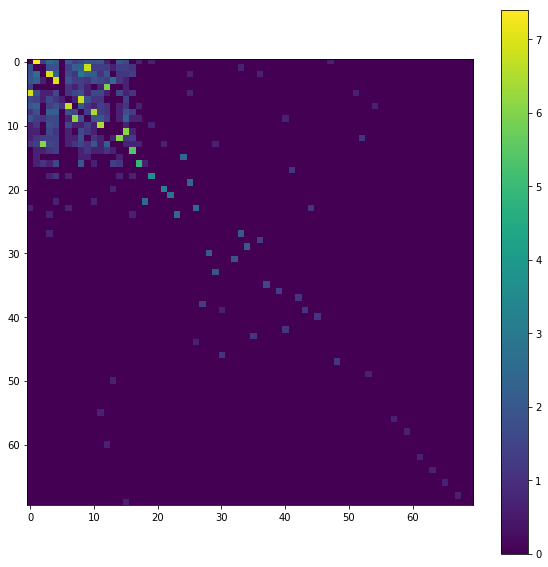

In [60]:
for gr_ in grs:
    pu.plot_gr(gr_[0][:100, :100], log = 1)

In [75]:
for gr_ in grs:
    print(gr_[0].sum())

24565.0
12113.0
102967.0
24649.0


In [116]:
with open("../data/student_Dvyg/EC/gz/25_0_0_grep") as f:
    lines = [x[:-1] for x in f.readlines()]

In [119]:
def split_read(read, quality, repeat, e=2, v=0):
    repeat, repeat_s, repeat_e = repeat.r, repeat.rs, repeat.re
    repeat_pos = find(repeat, read, e)
    
    if v: print(repeat_pos)
    if len(repeat_pos) == 0:
        return [-1, -1], [-1, -1]

    else:
        repeat_pos = repeat_pos[0]
        read_left = read[:repeat_pos[0]]
        q_left = quality[:repeat_pos[0]]
        
        read_right = read[repeat_pos[1]:]
        q_right = quality[repeat_pos[1]:]
        
        
        repeat_pos_l = find(repeat_e, read_left, e)
        if v: print(repeat_pos_l)
        if len(repeat_pos_l) == 0:
            left_spacer = -1
            left_sp_q = -1
        else:
            left_spacer = read_left[repeat_pos_l[0][1]:]
            left_sp_q = q_left[repeat_pos_l[0][1]:]
            
        
        repeat_pos_r = find(repeat_s, read_right, e)
        if v: print(repeat_pos_r)
        if len(repeat_pos_r) == 0:
            right_spacer = -1
            right_sp_q = -1
        else:
            right_spacer = read_right[:repeat_pos_r[0][0]]
            right_sp_q = q_right[:repeat_pos_r[0][0]]
            
        if left_spacer != -1 and len(left_spacer) <= 10:
            left_spacer = -1
        if right_spacer != -1 and len(right_spacer) <= 10:
            right_spacer = -1
        
        return [left_spacer, right_spacer], [left_sp_q, right_sp_q]

In [123]:
split_read(lines[0], lines[0], ecoli_r, e = 4, v = 1)

[]


([-1, -1], [-1, -1])

In [124]:
lines[0]

'CGCTAGCGCGGGGAACTCACATGAATGTCGGTTCAGACCGTGTTTTTACCCGGTTTATCCCCGCTGGCGCGGGGAACACAGTGCTGGACCATTTCAAATTCACAATAGATTCGGTTTATCCCCGCTGGCGCAGATCGGAAGAGCGTAGATC'

In [127]:
ecoli_r.rc

'GWGTTCCCCGCGCCAGCGGGGATAAACCG'

In [ ]:
CGGTTTATCCCCGCTGGCGCGGGGAACACCGTCCGGATCGGTTTCG

In [61]:
answ = [
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TAAACCACCAGCCAGACCACCAATTACCACAC	GCGATGGATCAGGGTATTACACTCGACGGCGG",
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TTTTGCTGACACCGGCAATACTGAACGGCTGG	ACGGATTGCGGTATATGCAGTGTCCAGATTCT	TAAACCACCAGCCAGACCACCAATTACCACAC	GGGGATAACGGTTATCCACTGGCCGCCGATCT	TGTAATAGCCTGATCTCTGATCTCCCTCGCCT	CTGTCCCAGGCCGAGGCTGTATTTCAATCCTG	GCGATGGATCAGGGTATTACACTCGACGGCGG	GCTGCGGGTCAATCAACTGGAGTGCAAATCCCC	GTCGCGCGCCGACGGGAATAAACCGAATAAATTT	TCGTCAGGCACATACTGAGTTCGCAACAAA",
    "CCCGCATTCAGACGTTTCAAATTGAGAGG	CCGTCCACCCTGATAGCCGCCCTTGTGATC	TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG	TCATTTCCCATGCAAAATGCTGCATTCCTGGC	AGTGGCAGGCCGGTAATATGAAAACGACAGAG	ATCTTCTTGTTCAGGAACGTCAGTAGAGGTGT	AGCATTAACCCCCACCAGCTCGACGTGTGTGG	GCGGGCGTTAACGCGGTGATACTGTTTGACGG	ACCGAGCGCCGCTGGGAGGCGTATCTCACGTT	TGAATGATCGGAAAGACGCTGCAAAGGCAATG	TACCAAACCGGAATCGCTCCATATAACGGCGG	CAACCCGGCGGCACGGTCAATCGTTGCGTCAG	GACTCAAAACGGCGCAGGTCAAAATCGTTCAA	GGTGAATACTGCGGCAGGCGCTGCGGGAATTG",
    "AACATCGGAAACGGCTTCGCGGCGGCGGCGTC	ACGTGAAGAATATTTGCAACACCCGCAAGAA	GGCATAGCCAGGCTGATCCGGCGACGGCCTTA	GCCCGCCTCGTCGGTGTATTCCGCGAGATCGC	GTTATCACCGAGTGCAGTAGCCCGCGCGCGCT	GTCGCCGGGTTGATTTTCCATGATGATTTTTA	GTAACGTGGCGACGACCGGCGATTGATTTCAG	TCGAACCTGTTTTTCTTAGTGCGCGCAACGTC	CGTCCGGATCGGTTTCGAGAATCTCTACGCTC	GTTGTTGTAATAAAGCCCCGGAGTTTTATATC	GGGTTGACGCCAGCGAACATTGACTCAGATGC	TACAGTTAAGCGTAAAGTAAGTGATACTGGTG	GTTTTCATTTGCACGAGCTGCACCATAAGAAG"
]

In [62]:
answ = [x.split("\t") for x in answ]

In [63]:
g = grs[0]

In [64]:
g[2]

{'CACCAGTATCACTTACTTTACGCTTAAC': 0,
 'GCATCTGAGTCAATGTTCGCTGGCGTC': 1,
 'GTGTGGTAATTGGTGGTCTGGCTGGTGG': 2,
 'GAAAAGCTACTTTTGTGTTCAACTGATG': 3,
 'GCATCTGAGTCAATGTTCGCTGGCGTCA': 1,
 'CCGCGCAAATCCAGCGAGCCGCCGAC': 4,
 'GAAAAGCTACTTTTGTGTTCAACTGAT': 3,
 'CTTCTTATGGTGCAGCTCGTGCAAATGA': 5,
 'GACGTTGCGCGCACTAAGAAAAACAGGT': 6,
 'GAGCGTAGAGATTCTCGAAACCGATCCG': 7,
 'CACCAGTATCACTTACTTTACGCTTAA': 0,
 'CTGAAATCAATCGCCGGTCGTCGCCAC': 8,
 'GATATAAAACTCCGGGGCTTTATTACA': 9,
 'GACGTTGCGCGCACTAAGAAAAACAGG': 6,
 'CTGAAATCAATCGCCGGTCGTCGCCACG': 8,
 'TAAAAATCATCATGGAAAATCAACCCGG': 10,
 'AGCGCGCGCGGGCTACTGCACTCGGTG': 11,
 'TAAAAATCATCATGGAAAATCAACCCG': 10,
 'GATATAAAACTCCGGGGCTTTATTACAA': 9,
 'TTGCAAACCGTGGCAAACGCAATTAACA': 12,
 'AGCGCGCGCGGGCTACTGCACTCGGTGA': 11,
 'CCGCCGTCGAGTGTAATACCCTGATCCA': 13,
 'CCGCGCAAATCCAGCGAGCCGCCGACG': 4,
 'GAGCGTAGAGATTCTCGAAACCGATCC': 7,
 'GTGTGGTAATTGGTGGTCTGGCTGGTG': 2,
 'ATTGTTATAATTATTTATTGAAATATC': 14,
 'GCGATCTCGCGGAATACACCGACGAGG': 15,
 'TTGCAAACCGTGGCAAACGCAATTAAC': 12,

In [65]:
answ[0][0]

'ACATGAATGTCGGTTCAGACCGTGTTTTTACC'

In [66]:
[[hu.find_closest(g[2], x[::]) for x in y] for y in answ]

[[(15, 'GATATAAAACTCCGGGACTTTATTACA'),
  (13, 'AACTCCAGGATATTGCAAACCGCATAGT'),
  (14, 'ATTGTTATAATTATTTATTGAAATATT'),
  (14, 'GTGTGGTAATTGGTGGTCCGGCTGGTG'),
  (12, 'AGCGCGCGCGGGCTACTGCACTTGGTGA'),
  (14, 'TTTGCTGGAACCCAAAACTCAGCGCAC'),
  (14, 'TTACAAACCGTGGCAAACGCAATTAACA'),
  (10, 'GCGATCTCGCGGAATACACCGACGAGG')],
 [(15, 'GATATAAAACTCCGGGACTTTATTACA'),
  (13, 'AACTCCAGGATATTGCAAACCGCATAGT'),
  (14, 'ATTGTTATAATTATTTATTGAAATATT'),
  (14, 'GTGTGGTAATTGGTGGTCCGGCTGGTG'),
  (12, 'AGCGCGCGCGGGCTACTGCACTTGGTGA'),
  (14, 'TTTGCTGGAACCCAAAACTCAGCGCAC'),
  (12, 'TTTGCTGGAACCCAAAACTCAGCGCAC'),
  (13, 'TACGTGTCGCCGTTACAGATTTCAGTCT'),
  (14, 'TTACAAACCGTGGCAAACGCAATTAACA'),
  (14, 'GAGCCTGACGAGACTACTGAGGCCGTT'),
  (13, 'TAAGGCCGTCGCCGGATCAGCCTGGCT'),
  (14, 'AGCGCGCGCGGGCTACTGCAATCGGTG'),
  (10, 'GCGATCTCGCGGAATACACCGACGAGG'),
  (15, 'GCATCTGAGTCAATGTTCGCTGGCGTCAACC'),
  (14, 'CCAGCGCCAGACGGGAACACAATTTTA'),
  (13, 'ACTATCGGCGCTGTTCAGTTGGGACAGA')],
 [(13, 'CGTGCCTTCGACTTTGCGGATCACGTCG'),
  (12, 'GG

In [71]:
with open("../data/student_Dvyg/EC/gz/25_0_0_grep") as f:
    lines = [x[:-1] for x in f.readlines()]

In [83]:
lines[-2]

'CGCTGGCGCGGGGAACACACATGAATGTCGGTTCAGACCGTGTTTTTACCCGGTTTATCCCCGCTGGCGCGGGGAACACAGTGCTGGACCATTTCAAATTCACAATAGATTCGGTTTATCCCCGCTGGCGCGGGGAACACGGAAAGATCGG'

In [80]:
split_read(lines[0], lines[0], ecoli_r_1, e = 6)

([-1, -1], [-1, -1])

In [82]:
ecoli_r_1.rc

'GCCAAATAGGGGCGACCGCGCCCCTTGWG'

In [85]:
rc(ecoli_r_1.rc)[::-1]

'CWCAAGGGGCGCGGTCGCCCCTATTTGGC'

In [86]:
%load_ext autoreload
%autoreload 2

In [79]:
ecoli_r = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GWGTTCCCCGCGCCAGCG",
                   "GCGCCAGCGGGGATAAACCG",
                   "GWGTTCCCCGCGCCAGCGGGGATAAACCG")

ecoli_r_1 = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GCCAAATAGGGGCGACCGCG",
                   "GCGACCGCGCCCCTTGWG",
                   "GCCAAATAGGGGCGACCGCGCCCCTTGWG")


In [ ]:
v

In [97]:
[[len(x) for x in y] for y in answ]

[[32, 32, 32, 32, 31, 32, 32, 32],
 [32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 33, 34, 30],
 [29, 30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 [32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]

In [106]:
(np.array([len(x) for y in res_20_1[0] for x in y]) == 28).sum()

44213

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.3050e+03, 4.4213e+04, 1.9110e+03,
        7.0600e+02, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([15.  , 16.55, 18.1 , 19.65, 21.2 , 22.75, 24.3 , 25.85, 27.4 ,
        28.95, 30.5 , 32.05, 33.6 , 35.15, 36.7 , 38.25, 39.8 , 41.35,
        42.9 , 44.45, 46.  ]),
 <a list of 20 Patch objects>)

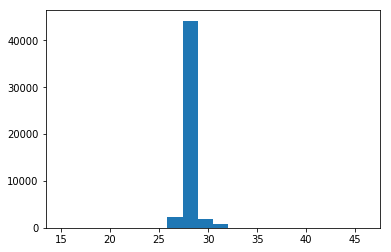

In [101]:
plt.hist([len(x) for y in res_20_1[0] for x in y], bins =20)

In [20]:
IUPAC_WILDCARDS

{'W': 'AT',
 'S': 'CG',
 'M': 'AC',
 'K': 'GT',
 'R': 'AG',
 'Y': 'CT',
 'B': 'CGT',
 'D': 'AGT',
 'H': 'ACT',
 'V': 'ACG',
 'N': 'ACGT'}

In [63]:
save_pairs("../data/clostr_Polina/pairs/", names[0], pairs)

In [ ]:
def save_pairs(path, name, pairs):
    name = name.split(".")[0]
    with open(path + name, 'w') as f:
        for p in pairs:
            f.write("\t".join(p))
            f.write("\n")
            

In [ ]:
[save_pairs(path, names[0]+'pairs', )]

In [18]:
reads, qualities = read_fastq(path)

In [20]:
pairs, pairs_q = [], []
for r,q in tqdm_notebook(zip(reads, qualities)):
    p, pq = split_read(r, q, repeat, repeat_s, repeat_e)
    pairs.append(p)
    pairs_q.append(pq)

In [22]:
pairs = np.array(pairs)
pairs_q = np.array(pairs_q)

In [25]:
mask = np.array(['-1' not in pair for pair in tqdm_notebook(pairs)])

print(mask.sum())

pairs = pairs[mask]
pairs_q = pairs_q[mask]

A Jupyter Widget


28815


In [53]:
min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])

In [363]:
pairs = np.array(pairs)

In [375]:
mask = np.array(['-1' not in pair for pair in pairs])

In [379]:
pairs[mask]

array([['GAGGAGATTCAGACAGCGACTAAAAAGACTGATATA',
        'AACTTTATATCTCCANTTGCATATCCATCTGATGA'],
       ['GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC',
        'CAGCCAAAAACTTCGAATTTGAACTAAAATGCGT'],
       ['AGGAGATAACTTCTATTAAAGATAACTTTGATGTG',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ...,
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGA',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGC',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['GCTTACAAGGTTGAGAAGCTCCGCAATCTCAAAGTCGT',
        'ATTTGAAATGAATAAATTTTAAATGAATGAAAGTATAG']], dtype='<U105')

(array([     0.,      0.,      0.,      0.,      0., 128171.,      0.,
             0.,      0.,      0.]),
 array([150.5, 150.6, 150.7, 150.8, 150.9, 151. , 151.1, 151.2, 151.3,
        151.4, 151.5]),
 <a list of 10 Patch objects>)

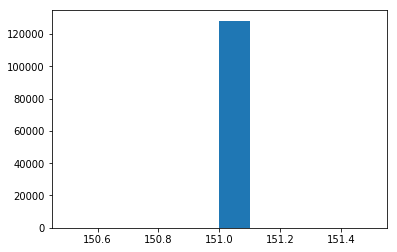

In [299]:
plt.hist([len(x) for x in reads])

In [312]:
len(quality_symbols)

95

In [313]:
quality_symbols[:15]

'!"#$%&\\\'()*+,-.'

In [316]:
qualities[100]

'AFFAFF=FFAFFFFFFFAFFFFFAFFFAFFFFFFFFFFFFFFFFFFFFFFFAFFFFFF/FFFFFFF6FAAFFFFFFFFF=FFFFFFFFFAFFFFFFFAFFF/FAFAF/FFFFF/FFF/FFFFFF=FFFFFFFFF/FFF/FFFFFFFFFFFF'

In [318]:
#  [sum([y in x for x in np.array(qualities)[mask]]) for y in quality_symbols]

In [232]:
p_str = repeat_to_re_pattern("(AAd)") 

In [233]:
p_str

'(AAd){e<=2}'

In [243]:
#p = re.compile("(AAAC){e<=2}")
p = re.compile(p_str)

In [244]:
[x.span() for x in re.finditer(p, "AAAA")]

[]

In [259]:
p_str = repeat_to_re_pattern(repeat,e=6)
p = re.compile(p_str)
print(p_str)

(GTTTTA[G|T]ATTAACTA[A|T][A|G]TGG[A|T]ATGTAAA[G|T]){e<=6}


In [260]:
[x.span() for x in re.finditer(p, reads[1])]

[(52, 84)]

In [261]:
reads[1][52:84]

'GGGTTTTAGATTAACTAAATGGAGATCGGAAG'

In [268]:
len(reads[1])

151

In [267]:
print_together(reads[1][54:84], repeat_clear)

G G
T T
T T
T T
T T
A A
G K
A A
T T
T T
A A
A A
C C
T T
A A
A W
A R
T T
G G
G G
A W
G A
A T
T G
C T
G A
G A
A A
A K


In [263]:
def print_together(s1, s2):
    for a,b in zip(s1, s2):
        print(a,b)

In [254]:
for  a,b in zip(reads[0], repeat[12:]):
    print(a, b)

A A
C C
T T
A A
T W
G R
T T
G G
G G
A )
A W
T A
G T
T G
A T
A A
A A
T A
G K


In [17]:
def repeat_matches(read, repeat, wildcards):
    pass

In [102]:
"|".join("ANB")

'A|N|B'

## import bio

In [154]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_nucleotide
from Bio.Alphabet import IUPAC
nuc_seq = Seq("GATCGATGC", generic_nucleotide)
dna_seq = Seq("ACGTW", IUPAC.unambiguous_dna)

In [152]:
IUPAC.ambiguous_dna

'GATCRYWSMKHBVDN'

In [151]:
IUPAC_WILDCARDS

{'W': 'AT',
 'S': 'CG',
 'M': 'AC',
 'K': 'GT',
 'R': 'AG',
 'Y': 'CT',
 'B': 'CGT',
 'D': 'AGT',
 'H': 'ACT',
 'V': 'ACG',
 'N': 'ACGT'}

## RE

In [206]:
import regex as re

In [96]:
p = re.compile('a[d|b]c')

In [98]:
re.findall(p, 'aabddcx')

[]

## Mastering spades

In [55]:
import sys
sys.path.append("../spget/")

from importlib import reload

In [56]:
import spget as sp
sp = reload(sp)

In [92]:
# path = "../data/clostr_test/fastq/test_1.fastq"
# path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/clostr_Polina/primers.txt"
rep = sp.load_repeats(r_path)













1	GTTTTAKATTA(ACTAWRTGG)WATGTAAAK	6



loading repeats from ../data/clostr_Polina/primers.txt


In [93]:
all_mm = {}
b = {}
sp.fill_parts(rep, all_mm, b )


using following repeats sequences:
seq: GTTTTAKATTAACTAWRTGGWATGTAAAK id: 0 types: 1(|1) mismatches: 6
seq: ACTAWRTGGWATGTAAAK id: 1 types: 1( mismatches: 6
seq: GTTTTAKATTAACTAWRTGG id: 2 types: 1) mismatches: 6


In [94]:
all_mm['GTTTTAKATTAACTAWRTGGWATGTAAAK']['RE_FUZZY']

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=6,i<=0,d<=0}', flags=regex.V0)

In [65]:
lines, q= read_fastq("../data/clostr_Polina/fastq/Polina-1_S11_L001_R1_001.fastq")

In [80]:
for pat in a:
    mm = all_mm[pat]["MM"]
    ins = all_mm[pat]["INS"]
    dl = all_mm[pat]["DEL"]
    pat_sys = all_mm[pat]["SYS"]
    pat_type = all_mm[pat]["TYPE"]
    pat_re_fuzzy = all_mm[pat]["RE_FUZZY"]
    pat_id = all_mm[pat]["ID"]
    found = sp.fuzzy_find_seq(lines[0], pat, mm, ins, dl, pat_re_fuzzy, pat_type, pat_id)

In [82]:
found

In [91]:
all_mm

{'GTTTTAKATTAACTAWRTGGWATGTAAAK': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1(', '1)'},
  'ID': '0',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)},
 'ACTAWRTGGWATGTAAAK': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1('},
  'ID': '1',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:ACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)},
 'GTTTTAKATTAACTAWRTGG': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1)'},
  'ID': '2',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGG){s<=2,i<=0,d<=0}', flags=regex.V0)}}

In [105]:
coords = sp.get_system_coords(lines[1], all_mm)

In [108]:
split_read(lines[0], q[1], redundant.rc, redundant.rs, redundant.re, v =1)

[(54, 85), (120, 151)]
[(0, 18)]
[(35, 57)]


(['GAGGAGATTCAGACAGCGACTAAAAAGACTGATATA',
  'AACTTTATATCTCCANTTGCATATCCATCTGATGA'],
 ['FFFFFFFFFFFFFFFF/FFAFFFFFFFFFFFFFFFF',
  'FFFFFFFFFFFFFFFFFFFFFFFFFFFFF=F/=//'])

In [72]:
a['GTTTTAKATTAACTAWRTGGWATGTAAAK']

{'MM': 2,
 'INS': 0,
 'DEL': 0,
 'SYS': {'1'},
 'TYPE': {'1(', '1)'},
 'ID': '0',
 'DA_SET': set(),
 'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)}

In [ ]:
sp.fuzzy_find_seq()

In [45]:
sp.rc(raw)

'ATTTACATTCCATATAGTTAATCTAAAACGTTCATCAGATGGATATGCAANTGGAGATATAAAGTTATTTACATTCCATATAGTTAATCTAAAACTTTATATCAGTCTTTTTAGTCGCTGTCTGAATCTCCTCATTTACATTCCACATAGT'

In [53]:
for r in raw:
    print(sp.get_system_coords(sp.rc(r), a))

{}
{}
{}
{}
{}
{}
{}
{}


In [54]:
for r in raw:
    print(sp.get_system_coords(r, a))

{}
{}
{}
{}
{}
{}
{}
{}


In [56]:
from spget import * 

In [58]:
path = "../data/clostr_test/fastq/test_1.fastq"
path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/scripts/primers.txt"
#rep = sp.load_repeats(r_path)

In [ ]:
repeats = load_repeats(r_path)
if not repeats:
    warn("no repeats loaded, exiting")
    exit(1)

all_mm = {}
id2primers = {}
fill_parts(repeats, all_mm, id2primers)


warn("\ntrimming...")

In [66]:
start_time = time.time()
for cnt, line in enumerate(lines, start = 1):
#     if cnt % time_each == 0 or cnt == args.time_first:
#         warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
#     if of_parts and cnt % of_parts != part:
#         continue

    print(line)
    rec = list(map(lambda x: x.strip(), line.strip().split("\t")))
    rec += [""]
    print(rec)
    place, read_id, seq, qual = rec[0:4]

    rc_seq = rc(seq)
    rc_qual = qual[::-1]

    res = get_system_coords(seq, all_mm)
    res_rc = get_system_coords(rc_seq, all_mm)

#     both_dirs = res and res_rc
#     dump_read(place, read_id, res, seq, id2primers, both_dirs, "+", qual, args.dump_linked_ids)
#     dump_read(place, read_id, res_rc, rc_seq, id2primers, both_dirs, "-", qual, args.dump_linked_ids)

# warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
# warn("\ndone...")

home	@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11	ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT	AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF

['home', '@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11', 'ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT', 'AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF', '']
home	@MN00409:27:000H2KHTM:1:11102:23264:1052 1:N:0:11	ACTATGTGGAATGTAAATCAGCCAAAAACTTCGAATTTGAACTAAAATGCGTGGGTTTTAGATTAACTAAATGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCCAGTATCATCTCGTATGCCGTCTTCGGCTTGAAAAAAATAAG	AAAFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFF/FFAFFFFFFFFFFFFFFFFFFF

In [74]:
def get_system_coords(seq, all_mm):
    out = defaultdict(list)
    for pat in all_mm:
        mm = all_mm[pat]["MM"]
        ins = all_mm[pat]["INS"]
        dl = all_mm[pat]["DEL"]
        pat_sys = all_mm[pat]["SYS"]
        pat_type = all_mm[pat]["TYPE"]
        pat_re_fuzzy = all_mm[pat]["RE_FUZZY"]
        pat_id = all_mm[pat]["ID"]
        found = fuzzy_find_seq(seq, pat, mm, ins, dl, pat_re_fuzzy, pat_type, pat_id)
        print(found)
        if found:
            for sys in pat_sys:
                out[sys] += found
    res = {}
    for sys in out:
        pruned = prune_matches(out[sys], sys)
        if pruned:
            res[sys] = pruned
    return res


In [83]:
def fuzzy_find_seq(where, what, mm, ins, dl, what_re_fuzzy, pat_type = None, pat_id = None):
    '''returns [(mm, from, to, substr)]'''
    if mm < 0:
        mm = 0
        
        
    print(what_re_fuzzy)
        
    print(where, "\n", what)
    out = []
    
    print(what_re_fuzzy.find(where, overlapped=True))
    positions = [(i.span()[0], i.span()[1], i[0], i.fuzzy_counts[0], i.fuzzy_counts[1], i.fuzzy_counts[2]) for i in what_re_fuzzy.finditer(where, overlapped=True)]

    positions = filter(lambda x: x[3] <= mm and x[4] <= ins and x[5] <= dl, positions)
    
    for frm, to, match, dist_mm, dist_ins, dist_del in positions:
        out.append((dist_mm + dist_ins + dist_del, frm, to, match, pat_type, pat_id))
    if not out:
        return None
    return out

In [89]:
re = all_mm['GTTTTAKATTAACTAWRTGGWATGTAAAK']['RE_FUZZY']

In [91]:
re

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)

In [90]:
re.findall(raw[0])

[]

In [84]:
get_system_coords(raw[0], all_mm)

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGGWATGTAAAK
None
regex.Regex('(?:ACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 ACTAWRTGGWATGTAAAK
None
regex.Regex('(?:GTTTTAKATTAACTAWRTGG){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGG
None


{}

In [ ]:
fuzzy_find_seq(raw[0], )

In [2]:
False and 'T' or 'F'

'F'